# Hybrid Recommender System

Домашнее задание №4. Гибридная рекомендательная система.

В качестве обучающего датасэта можно использовать любой, но рекомендуется использовать датасэт REKKO https://boosters.pro/championship/rekko_challenge/data.
Нужно реализовать (или использовать сделанный из предыдущих домашних работ)
1. SVD-разложение
2. Архитектуру Neural matrix factorization model (NeuMF) (см. лекцию и сем по нейронным сетям + https://arxiv.org/pdf/1708.05031.pdf +  https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation), на вход которой подаются:
    - эмбединги длинны n по users 
    - эмбединги длинны n по items  
3. Гибридную архитектуру нейронную сеть, которая на вход получает:
    - эмбединги длинны n по users 
    - эмбединги длинны n по items 
    - признаки, которые можно извлечь из объекта (см.  baseline.ipynb, который есть в датасэт REKKO.)
    - признаки по пользователю (подумайте какие например можно извлечь из bookmarks.csv)

Если вы используете другой датасэт, то признаки могу быть другими.
Для гибридную архитектуру можно использовать NeuMF, рядом подать дополнительные входы. Их можно провязать полносвязанными слоями с основной частью. Можно это делать разными способами ближе к началу сети, или ближе концу. Попробуйте разные архитектуры, оцените их качество и скорость обучения. Обоснуйте свой финальный выбор.

Сравнить:
- SVD-разложения (построенного на только rating.csv) на  8, 10, 12 компонент
- Архитектуру NeuMF, где на вход подаются на SVD-разложения 8, 10, 12 компонент
- Гибридную архитектуру, где на вход подаются на SVD-разложения 8, 10, 12 компонент

Дополнительно можно поисследовать какие-то параметры архитектур. 
Для оценки качества используйте кросс-валидацию на 3 фолда.

## Load Data

### Все таблицы

In [1]:
DATA_PATH = '/home/ilya/repos/recsys/data/rekko'

In [2]:
import pandas as pd
import os
import numpy as np

ratings = pd.read_csv(
    os.path.join(DATA_PATH, 'ratings.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64,
        'rating': np.uint8
    }
)
print(ratings.shape)
ratings.head()

(438790, 4)


,user_uid,element_uid,rating,ts
0,571252,1364,10,4.430517e+07
1,63140,3037,10,4.430514e+07
2,443817,4363,8,4.430514e+07
3,359870,1364,10,4.430506e+07
4,359870,3578,9,4.430506e+07


In [3]:
transactions = pd.read_csv(
    os.path.join(DATA_PATH, 'transactions.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'consumption_mode': 'category',
        'ts': np.float64,
        'watched_time': np.uint64,
        'device_type': np.uint8,
        'device_manufacturer': np.uint8
    }
)
print(transactions.shape)
transactions.head()

(9643012, 7)


,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


In [4]:
import json

catalogue = json.load(open(os.path.join(DATA_PATH, 'catalogue.json'), 'r'))
catalogue = {int(k): v for k, v in catalogue.items()}
catalogue[1]

{'type': 'movie',
 'availability': ['purchase', 'rent'],
 'duration': 120,
 'feature_1': 6610431.116079764,
 'feature_2': 0.7732243944,
 'feature_3': 3,
 'feature_4': 1.1120138405,
 'feature_5': 0.6547073468,
 'attributes': [2786, 385, 2799, 3730, 886, 7, 11700, 42, 20, 388, 1934]}

 - `attributes` — мешок атрибутов
 - `availability` — доступность (может содержать значения `purchase`, `rent` и `subscription`)
 - `duration` — длительность в минутах, округлённая до десятков (продолжительность серии для сериалов и многосерийных фильмов)
 - `feature_1..5` — пять анонимизированных вещественных и порядковых признаков
 - `type` — принимает значения `movie`, `multipart_movie` или `series`

In [5]:
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)
print(bookmarks.shape)
bookmarks.head()

(948216, 3)


,user_uid,element_uid,ts
0,301135,7185,4.430516e+07
1,301135,4083,4.430516e+07
2,301135,10158,4.430516e+07
3,301135,2693,4.430516e+07
4,301135,2181,4.430515e+07


### Где признаки для айтемов?

Кажется они в `catalogue.json`. Если это так, то ключи в этом файле --- это element_uid. Провалидирую что во всех остальных таблицах встречается подмножество этих ключей и никакие другие.

In [6]:
set1 = set(catalogue.keys())
set2 = set(ratings.element_uid.unique().tolist())
set3 = set(transactions.element_uid.unique().tolist())
set4 = set(bookmarks.element_uid.unique())

In [7]:
sets = [set1, set2, set3, set4]
n = len(sets)
res = np.zeros((n, n), dtype=np.int_)
for i in range(n):
    for j in range(i,n):
        res[i, j] = len(sets[i].intersection(sets[j]))
res

array([[10200,  7519,  8296,  9489],
       [    0,  7519,  7145,  7482],
       [    0,     0,  8296,  8230],
       [    0,     0,     0,  9489]])

Действительно, множество ключей в дикте `catalogue.json` включает element_uid из всех таблиц.

In [8]:
item_id_inner2orig = sorted(list(set1 | set2 | set3 | set4))
item_id_orig2inner = {x: i for i, x in enumerate(item_id_inner2orig)}
len(item_id_inner2orig)

10200

### Где признаки пользователей?

Отдельной таблицы как для айтемов тут нет.

Для каждого пользователя из `bookmarks.csv` взять признаки:
- сколько фильмов сохранено в закладках
- сколько времени разделяет добавление первой и последней закладок

Для каждой пары "пользователь--айтем" стоит на лету добавлять признаки:
- есть ли фильм в закладках
- признаки о транзакции из `transactions.csv`, если присутствует для данной пары

In [9]:
set1 = set(bookmarks.user_uid.unique().tolist())
set2 = set(ratings.user_uid.unique().tolist())
set3 = set(transactions.user_uid.unique().tolist())

In [10]:
sets = [set1, set2, set3]
n = len(sets)
res = np.zeros((n, n), dtype=np.int_)
for i in range(n):
    for j in range(i,n):
        res[i, j] = len(sets[i].intersection(sets[j]))
res

array([[147167,  47555, 146982],
       [     0, 104563, 104226],
       [     0,      0, 499663]])

In [11]:
user_id_inner2orig = sorted(list(set1 | set2 | set3))
user_id_orig2inner = {x: i for i, x in enumerate(user_id_inner2orig)}
len(user_id_inner2orig)

500000

## EDA for `catalogue.json`

In [12]:
catalogue[1]

{'type': 'movie',
 'availability': ['purchase', 'rent'],
 'duration': 120,
 'feature_1': 6610431.116079764,
 'feature_2': 0.7732243944,
 'feature_3': 3,
 'feature_4': 1.1120138405,
 'feature_5': 0.6547073468,
 'attributes': [2786, 385, 2799, 3730, 886, 7, 11700, 42, 20, 388, 1934]}

- `availability` -> вектор из индикаторов самых популярных атрибутов
- `duration` -> z-score
- `feature_1`, `feature_3`, `feature_4` -> минмакс шкалирование
- `feature_2` все ок
- `feature_5` -> one-hot по значениям `0., 0.44966669, 0.59271611, 0.65470735, 0.6804097`, а -1 заменю на самое популярное (0.65).
- `attributes` -> вектор индикаторов (самых популярных)

### `attributes`

In [13]:
import itertools as it

all_attrs = list(it.chain.from_iterable([item['attributes'] for item in catalogue.values()]))
unique_attrs = sorted(list(set(all_attrs)))
len(unique_attrs)

35869

In [14]:
from tqdm.autonotebook import tqdm
from tqdm.contrib.concurrent import process_map

def count_occurences(attr):
    return sum(attr in item['attributes'] for item in catalogue.values())

occurences = process_map(count_occurences, unique_attrs, max_workers=12, chunksize=10)
occurences_frac = np.array(occurences) / len(catalogue)

/tmp/ipykernel_17187/3428886715.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


100%|██████████| 35869/35869 [00:16<00:00, 2207.83it/s]


Нет фильмов без атрибутов:

In [15]:
sum(len(item['attributes']) > 0 for item in catalogue.values())

10200

Но так же нет универсальнных атрибутов, все они крайне редки:

In [16]:
np.mean(occurences_frac > .001)

0.027879227187822354

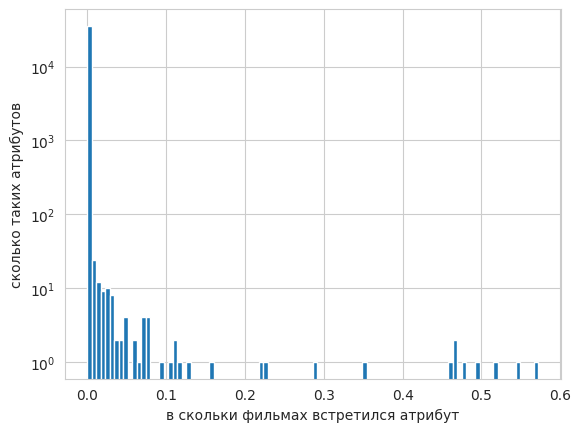

In [17]:
import seaborn as sns
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
plt.hist(occurences_frac, bins=100)
plt.yscale('log')
plt.ylabel('сколько таких атрибутов')
plt.xlabel('в скольки фильмах встретился атрибут')
plt.show()

В качестве признаков буду использовать индикаторы атрибутов, которые встретились более чем в 5% фильмах (всего таких 31 штук).

In [18]:
np.sum(occurences_frac > .05)

31

Номера этих атрибутов:

In [19]:
selected_attrs = [attr for i, attr in enumerate(unique_attrs) if occurences_frac[i] > .05]
print(selected_attrs)

[7, 10, 11, 14, 15, 17, 18, 19, 20, 21, 25, 31, 32, 33, 42, 43, 51, 52, 54, 55, 83, 123, 131, 151, 270, 272, 308, 388, 396, 1134, 1492]


### `duration`

z-score тут к месту, потому что распределение колоколообразное:

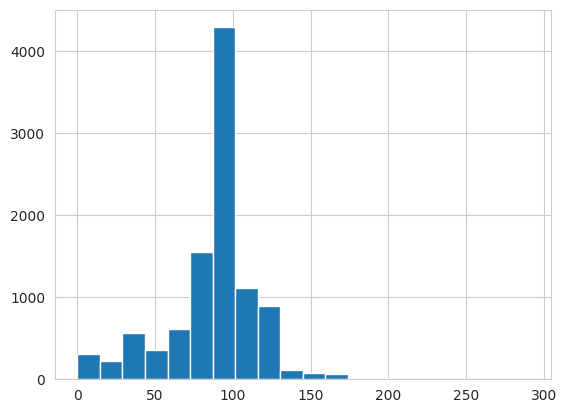

In [20]:
durations = [item['duration'] for item in catalogue.values()]
plt.hist(durations, bins=20)
plt.show()

### `feature_1`

Минмакс шкалирование нужно, чтобы избавиться от таких больших масштабов.

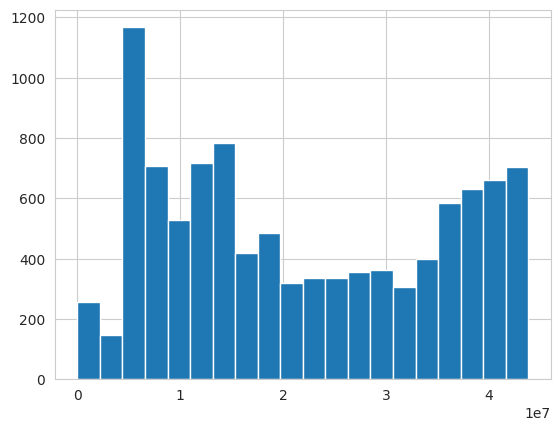

In [21]:
feature_1 = [item['feature_1'] for item in catalogue.values()]
plt.hist(feature_1, bins=20)
plt.show()

### `feature_2`

И так все ок

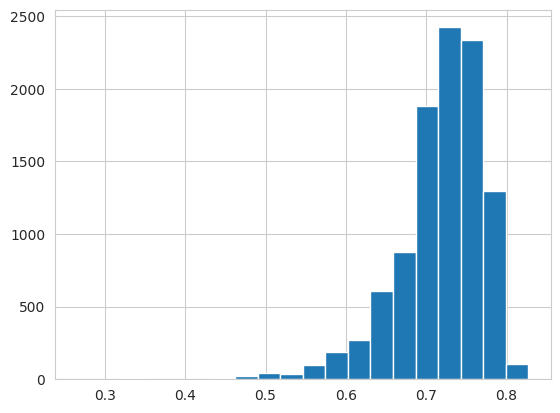

In [22]:
feature_2 = [item['feature_2'] for item in catalogue.values()]
plt.hist(feature_2, bins=20)
plt.show()

### `feature_3`

нужен минмакс

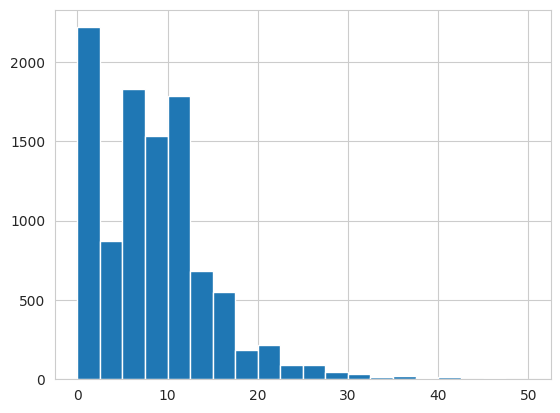

In [23]:
feature_3 = [item['feature_3'] for item in catalogue.values()]
plt.hist(feature_3, bins=20)
plt.show()

### `feature_4`

нужен минмакс

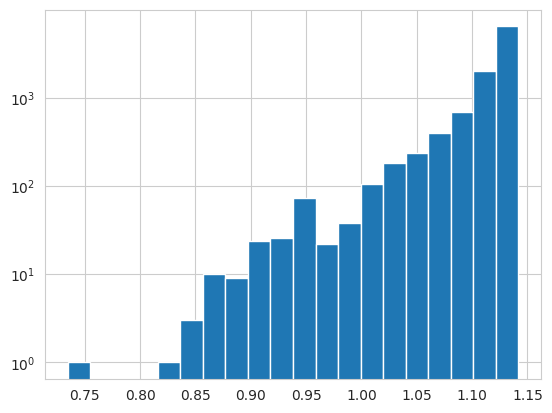

In [24]:
feature_4 = [item['feature_4'] for item in catalogue.values()]
plt.hist(feature_4, bins=20)
plt.yscale('log')
plt.show()

### `feature_5`

Тут есть пропуски (значения -1)

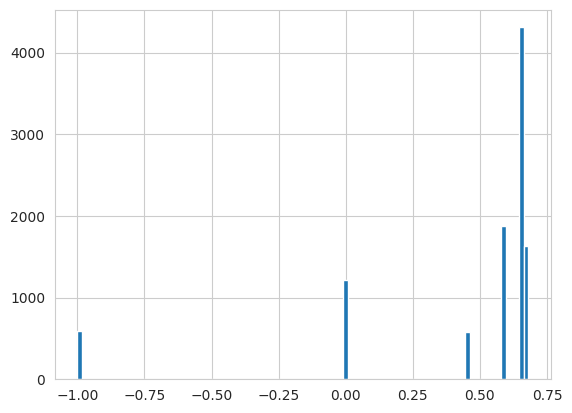

In [25]:
feature_5 = [item['feature_5'] for item in catalogue.values()]
plt.hist(feature_5, bins=100)
plt.show()

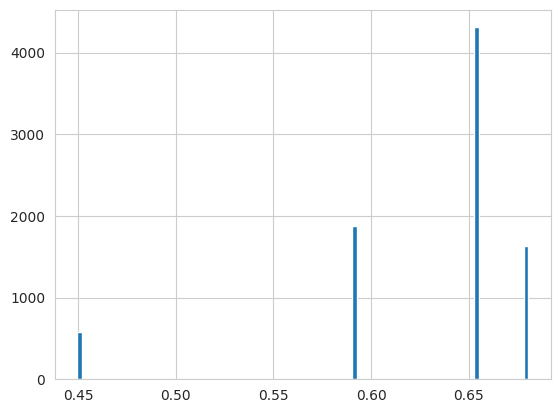

In [26]:
x = np.array(feature_5)
x = x[x > .25]
plt.hist(x, bins=100)
plt.show()

нужен one-hot, а -1 заменю на самое популярное (0.65).

In [27]:
feature_5_uniques = np.unique(feature_5).tolist()
print(feature_5_uniques)

[-1.0, 0.0, 0.4496666915, 0.5927161087, 0.6547073468, 0.6804096966]


### `type`

In [28]:
item_type = [item['type'] for item in catalogue.values()]
set(item_type)

{'movie', 'multipart_movie', 'series'}

### `availability`

In [29]:
availability = it.chain.from_iterable([item['availability'] for item in catalogue.values()])
set(availability)

{'purchase', 'rent', 'subscription'}

## Preprocessing & Feature Crafting for `catalogue.json`

In [30]:
def zscore(array):
    return (np.array(array) - np.mean(array)) / np.std(array)

def minmax(array):
    return (np.array(array) - np.min(array)) / (np.max(array) - np.min(array))

def feature_5_processor(array):
    array = np.array(array)
    array[array == -1] = feature_5_uniques[-2]
    tmp = feature_5_uniques[1:]
    res = [[int(x == t) for t in tmp] for x in array]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'feature_5_{i}' for i in range(1, len(feature_5_uniques))]
    )

def attributes_processor():
    res = [[int(attr in item['attributes']) for attr in selected_attrs] for item in catalogue.values()]
    attributes_df = pd.DataFrame(
        data=np.array(res),
        columns=[f'attr_{attr}' for attr in selected_attrs]
    )
    return attributes_df

def type_processor():
    selected_types = ['movie', 'multipart_movie', 'series']
    res = [[int(x == t) for t in selected_types] for x in item_type]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'type_{attr}' for attr in selected_types]
    )
    
def availability_processor():
    selected_avail = ['purchase', 'rent', 'subscription']
    column = [item['availability'] for item in catalogue.values()]
    res = [[int(t in x) for t in selected_avail] for x in column]
    return pd.DataFrame(
        data=np.array(res),
        columns=[f'avail_{attr}' for attr in selected_avail]
    )

In [31]:
feature_5_processor(feature_5).head()

,feature_5_1,feature_5_2,feature_5_3,feature_5_4,feature_5_5
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0


In [32]:
attributes_processor().head()

,attr_7,attr_10,attr_11,attr_14,attr_15,attr_17,attr_18,attr_19,attr_20,attr_21,...,attr_123,attr_131,attr_151,attr_270,attr_272,attr_308,attr_388,attr_396,attr_1134,attr_1492
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
type_processor().head()

,type_movie,type_multipart_movie,type_series
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [34]:
availability_processor().head()

,avail_purchase,avail_rent,avail_subscription
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,0


In [35]:
rest = pd.DataFrame({
    'element_uid': list(catalogue.keys()),
    'duration': zscore(durations),
    'feature_1': minmax(feature_1),
    'feature_2': feature_2,
    'feature_3': minmax(feature_3),
    'feature_4': minmax(feature_4),
})
rest.head()

,element_uid,duration,feature_1,feature_2,feature_3,feature_4
0,1983,1.796995,0.037828,0.753610,0.78,0.944740
1,3783,0.769968,0.811865,0.766254,0.82,0.991841
2,5208,0.085284,0.302935,0.765425,0.54,0.975163
3,9744,1.112311,0.496496,0.757874,0.52,0.979379
4,1912,0.769968,0.210307,0.759566,0.14,0.921965


In [36]:
catalogue_df = pd.concat([
    rest,
    feature_5_processor(feature_5),
    attributes_processor(),
    type_processor(),
    availability_processor(),
], axis=1)
catalogue_df.head()

,element_uid,duration,feature_1,feature_2,feature_3,feature_4,feature_5_1,feature_5_2,feature_5_3,feature_5_4,...,attr_388,attr_396,attr_1134,attr_1492,type_movie,type_multipart_movie,type_series,avail_purchase,avail_rent,avail_subscription
0,1983,1.796995,0.037828,0.753610,0.78,0.944740,1,0,0,0,...,0,0,0,0,1,0,0,1,1,1
1,3783,0.769968,0.811865,0.766254,0.82,0.991841,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
2,5208,0.085284,0.302935,0.765425,0.54,0.975163,0,0,1,0,...,0,0,0,0,1,0,0,1,1,1
3,9744,1.112311,0.496496,0.757874,0.52,0.979379,0,0,0,1,...,0,0,0,0,1,0,0,1,1,1
4,1912,0.769968,0.210307,0.759566,0.14,0.921965,0,0,0,1,...,0,0,0,0,1,0,0,1,1,0


In [37]:
catalogue_df['item_id'] = catalogue_df.element_uid.map(item_id_orig2inner)
catalogue_df.head()

,element_uid,duration,feature_1,feature_2,feature_3,feature_4,feature_5_1,feature_5_2,feature_5_3,feature_5_4,...,attr_396,attr_1134,attr_1492,type_movie,type_multipart_movie,type_series,avail_purchase,avail_rent,avail_subscription,item_id
0,1983,1.796995,0.037828,0.753610,0.78,0.944740,1,0,0,0,...,0,0,0,1,0,0,1,1,1,1983
1,3783,0.769968,0.811865,0.766254,0.82,0.991841,0,0,0,1,...,0,0,0,1,0,0,1,1,1,3783
2,5208,0.085284,0.302935,0.765425,0.54,0.975163,0,0,1,0,...,0,0,0,1,0,0,1,1,1,5208
3,9744,1.112311,0.496496,0.757874,0.52,0.979379,0,0,0,1,...,0,0,0,1,0,0,1,1,1,9744
4,1912,0.769968,0.210307,0.759566,0.14,0.921965,0,0,0,1,...,0,0,0,1,0,0,1,1,0,1912


In [38]:
folder = os.path.join(DATA_PATH, 'hw4')
if not os.path.exists(folder):
    os.makedirs(folder)

path = os.path.join(folder, 'catalogue.csv')
catalogue_df.to_csv(path, index=False)

## EDA for `transactions.csv`

In [39]:
transactions.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer
0,3336,5177,S,4.430518e+07,4282,0,50
1,481,593316,S,4.430518e+07,2989,0,11
2,4128,262355,S,4.430518e+07,833,0,50
3,6272,74296,S,4.430518e+07,2530,0,99
4,5543,340623,P,4.430518e+07,6282,0,50


In [40]:
transactions.describe()

,element_uid,user_uid,ts,watched_time,device_type,device_manufacturer
count,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06,9.643012e+06
mean,4.903627e+03,2.972156e+05,4.308295e+07,6.338216e+03,7.113436e-01,5.378050e+01
std,2.962026e+03,1.710970e+05,7.459096e+05,1.823438e+04,1.523222e+00,3.064894e+01
min,0.000000e+00,0.000000e+00,4.173063e+07,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.332000e+03,1.489950e+05,4.243755e+07,9.780000e+02,0.000000e+00,5.000000e+01
50%,4.661000e+03,2.973630e+05,4.314893e+07,4.959000e+03,0.000000e+00,5.000000e+01
75%,7.433000e+03,4.453270e+05,4.372865e+07,6.446000e+03,0.000000e+00,9.000000e+01
max,1.019900e+04,5.934890e+05,4.430518e+07,4.326296e+06,6.000000e+00,9.900000e+01


In [41]:
transactions.isna().sum(axis=0)

element_uid            0
user_uid               0
consumption_mode       0
ts                     0
watched_time           0
device_type            0
device_manufacturer    0
dtype: int64

- `ts` -> минмакс
- `watched_time` -> z-score
- `device_type` -> one-hot
- `device_manufacturer` -> индикатор топ-5 популярных значений
- `consumption_mode` -> one-hot

### `device_type`

ванхот однозначно

In [42]:
transactions.device_type.unique()

array([0, 3, 5, 4, 1, 6, 2], dtype=uint8)

### `device_manufacturer`

Возьму индикаторы топа пяти

In [43]:
transactions.device_manufacturer.unique()

array([50, 11, 99, 31, 67, 90, 85, 76, 94, 41, 82, 52, 20,  0, 38,  2, 37,
       59, 42, 57, 62, 97, 40, 44, 78, 80, 79, 86, 71,  5, 27, 26, 33, 30,
       98,  4, 93, 73, 15, 12, 48, 32,  3, 39, 24, 95, 21, 43, 56, 89, 51,
       87, 28, 55, 66, 19, 70, 64, 22, 35, 68,  8,  7, 17, 16, 46, 58, 77,
       36, 34, 63, 84, 18, 60, 91,  6, 96, 23, 47, 81, 53,  1, 13, 45, 54,
       88, 61, 69, 10, 75, 65, 74, 72, 25,  9, 14, 92, 83, 29, 49],
      dtype=uint8)

In [44]:
sorted_tr = transactions.device_manufacturer.value_counts(normalize=True, sort=True, ascending=False)
sorted_tr

device_manufacturer
50    0.457989
11    0.234171
99    0.186585
90    0.067116
76    0.022737
        ...   
46    0.000002
71    0.000002
54    0.000002
84    0.000002
69    0.000001
Name: proportion, Length: 100, dtype: float64

In [45]:
selected_manufacturers = sorted(sorted_tr[:5].index.tolist())
selected_manufacturers

[11, 50, 76, 90, 99]

## Preprocessing & Feature Crafting for `transactions.csv`

In [46]:
cons_modes = ['P', 'S', 'R']
consumption_mode_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in cons_modes] for x in transactions.consumption_mode]),
    columns=[f'cons_{x}' for x in cons_modes]
)

In [47]:
device_types = [0,1,3,5]
device_type_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in device_types] for x in transactions.device_type]),
    columns=[f'device_{x}' for x in device_types]
)
device_type_df.head()

,device_0,device_1,device_3,device_5
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [48]:
manufacturers_df = pd.DataFrame(
    data=np.array([[int(t == x) for t in selected_manufacturers] for x in transactions.device_manufacturer]),
    columns=[f'manuf_{x}' for x in selected_manufacturers]
)
manufacturers_df.head()

,manuf_11,manuf_50,manuf_76,manuf_90,manuf_99
0,0,1,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0


In [49]:
transactions_copy = transactions.copy()
transactions_copy['ts'] = minmax(transactions['ts'])
transactions_copy['watched_time'] = zscore(transactions['watched_time'])

transactions_copy = pd.concat([
    transactions_copy, consumption_mode_df, device_type_df, manufacturers_df
], axis=1)
transactions_copy.head()

,element_uid,user_uid,consumption_mode,ts,watched_time,device_type,device_manufacturer,cons_P,cons_S,cons_R,device_0,device_1,device_3,device_5,manuf_11,manuf_50,manuf_76,manuf_90,manuf_99
0,3336,5177,S,1.000000,-0.112766,0,50,0,1,0,1,0,0,0,0,1,0,0,0
1,481,593316,S,1.000000,-0.183676,0,11,0,1,0,1,0,0,0,1,0,0,0,0
2,4128,262355,S,1.000000,-0.301914,0,50,0,1,0,1,0,0,0,0,1,0,0,0
3,6272,74296,S,1.000000,-0.208848,0,99,0,1,0,1,0,0,0,0,0,0,0,1
4,5543,340623,P,0.999999,-0.003083,0,50,1,0,0,1,0,0,0,0,1,0,0,0


In [50]:
transactions_copy['item_id'] = transactions_copy.element_uid.map(item_id_orig2inner)
transactions_copy['user_id'] = transactions_copy.user_uid.map(user_id_orig2inner)

In [51]:
path = os.path.join(folder, 'transactions.csv')
transactions_copy.to_csv(path, index=False)

## EDA for `bookmarks.csv`

In [52]:
n_bookmarks = bookmarks.groupby('user_uid')['element_uid'].count().sort_values(ascending=False)
n_bookmarks

user_uid
30941     747
370803    696
551244    560
466218    524
187013    513
         ... 
256867      1
103102      1
103103      1
417893      1
138888      1
Name: element_uid, Length: 147167, dtype: int64

In [53]:
n_bookmarks = n_bookmarks.to_dict()
path = os.path.join(folder, 'n_bookmarks.json')
json.dump(n_bookmarks, open(path, 'w'))

In [54]:
ts = bookmarks.groupby('user_uid')['ts']
delta_ts = ts.max() - ts.min()
delta_ts

user_uid
3         1.749316e+06
8         0.000000e+00
9         6.005915e+05
14        1.377270e+06
16        2.072344e+06
              ...     
593460    2.244733e+06
593462    0.000000e+00
593464    1.142825e+06
593467    0.000000e+00
593482    7.836367e+05
Name: ts, Length: 147167, dtype: float64

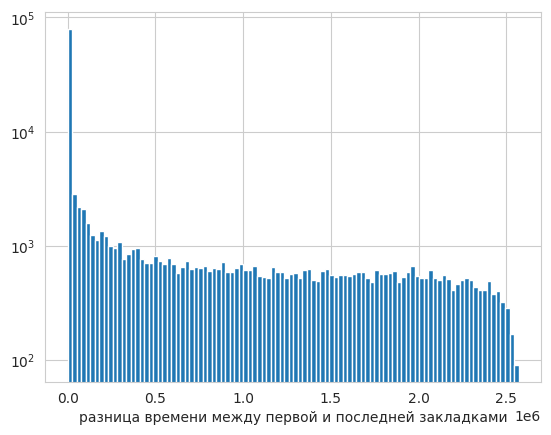

In [55]:
plt.hist(delta_ts, bins=100)
plt.yscale('log')
plt.xlabel('разница времени между первой и последней закладками')
plt.show()

In [56]:
delta_ts_values = delta_ts.values
delta_ts_values[delta_ts_values == 0] = 1
delta_ts_values = np.log(delta_ts_values)

delta_ts_index = delta_ts.index.map(user_id_orig2inner)
delta_ts_scaled = pd.Series(data=delta_ts_values, index=delta_ts_index)
delta_ts_scaled

user_uid
3         14.374736
7          0.000000
8         13.305670
13        14.135614
14        14.544191
            ...    
499979    14.624097
499981     0.000000
499983    13.949014
499985     0.000000
499994    13.571701
Length: 147167, dtype: float64

In [57]:
path = os.path.join(folder, 'delta_ts.json')
json.dump(delta_ts_scaled.to_dict(), open(path, 'w'))